In [1]:
from dotenv import load_dotenv
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.documents import Document
from langchain_community.tools import DuckDuckGoSearchRun
from typing import TypedDict, Optional
from operator import itemgetter
import re
import os

In [2]:
load_dotenv()

# Initialize APIs
youtube = build('youtube', 'v3', developerKey=os.getenv("YOUTUBE_API_KEY"))
embedder = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

In [3]:
class SearchResult:
    def __init__(self, search_result):
        self.video_id = search_result['id']['videoId']
        self.title = search_result['snippet']['title']
        self.transcript = self._get_transcript()

    def _get_transcript(self):
        try:
            transcript_list = YouTubeTranscriptApi.get_transcript(self.video_id)
            return " ".join([item['text'] for item in transcript_list])
        except Exception as e:
            print(f"Transcript error for {self.video_id}: {str(e)}")
            return ""

In [4]:
def search_yt(query, max_results=3):
    try:
        request = youtube.search().list(
            part="snippet",
            maxResults=max_results,
            q=query,
            videoCaption='closedCaption',
            type='video',
        )
        return request.execute().get('items', [])
    except Exception as e:
        print(f"YouTube API error: {str(e)}")
        return []

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
def create_faiss_index(items):
    documents = []
    for item in items:
        result = SearchResult(item)
        if not result.transcript:
            continue
            
        full_text = f"Title: {result.title}\nTranscript: {result.transcript}"
        chunks = text_splitter.split_text(full_text)
        
        for chunk in chunks:
            documents.append(Document(
                page_content=chunk,
                metadata={
                    "video_id": result.video_id,
                    "title": result.title
                }
            ))
    
    if not documents:
        print("No valid documents created")
        return None
    
    try:
        return FAISS.from_documents(documents, embedder)
    except Exception as e:
        print(f"FAISS error: {str(e)}")
        return None

In [7]:
# Graph state
class State(TypedDict, total=False):
    topic: str
    author: str
    question: str
    objective_check: bool
    youtube_summary: str
    recent_fact_checks: str
    validate_yt_summary: str
    validate_fact_checks: str
    generate_summary: str

In [8]:
from typing import Optional
from langchain_core.runnables import RunnableLambda

In [165]:
def get_user_input(state: State):
    print("a")
    return {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "investment strategy in 2025 ?",
        #"question": "is buying a house a good investment?",
        # "objective_check": None,
        # "youtube_summary": "",
        # "recent_fact_checks": "",
        # "validate_yt_summary": "",
        # "validate_fact_checks": None,
        # "generate_summary": ""
    }

In [166]:
def YouTube_search(state: State):

    print("\n=== Starting YouTube Search ===")
    print(f"YouTube Search... {state['topic']} on  {state['author']}")
    
    # Step 1: Search YouTube
    items = search_yt(f"{state['topic']} {state['author']}")
    if not items:
        print("❌ No search results found")
        return state
    print("✅ Valid search results found")
    
    # Step 2: Create FAISS index
    faiss_index = create_faiss_index(items)
    if not faiss_index:
        print("❌ FAISS index creation failed")
        return state
    print("✅ FAISS index created successfully")
    
    # Step 3: Setup RAG chain
    template = """Analyze and respond as {author} would. Rules:
    1. Use ONLY provided context
    2. Maintain {author}'s style
    3. State "Need information" if context is insufficient
    
    Context: {context}
    Question: {question}
    {author}'s analysis:"""
    
    prompt = ChatPromptTemplate.from_template(template)
    
    rag_chain = (
        {"context": faiss_index.as_retriever(), 
            "question": RunnablePassthrough(),
            "author": lambda _: state["author"]}
        | prompt 
        | llm
        | StrOutputParser()
    )
    
    # Step 4: Generate summary
    state["youtube_summary"] = rag_chain.invoke(state["question"])
    print("✅ YouTube summary generated successfully")
    return state
    

In [167]:
def validate_user_input(state: State):
    validation_prompt = f"""**Relevance Validation Task**
    
    Author: {state['author']}
    Topic: {state['topic']}
    Question: {state['question']}

    **Rules:**
    1. Focus on financial/economic concepts for "Rich Dad Poor Dad" topics
    2. Consider {state['author']}'s known expertise
    3. Allow tangential but related concepts (e.g., assets, investments, cash flow)
    4. Reject completely unrelated topics (e.g., romance, sports, politics)

    **Examples:**
    - Topic: Assets | Question: "Is a house an asset?" → True
    - Topic: Investing | Question: "Best stocks in 2024?" → True  
    - Topic: Cash Flow | Question: "How to find true love?" → False

    **Decision:**
    Respond ONLY with 'True' or 'False'"""

    print(f"Validating: '{state['question']}' against topic: '{state['topic']}'")

    response = llm.invoke(validation_prompt).content.strip().lower()
    is_valid = response == "true"
        
    print(f"Validation result: {is_valid} | Raw response: '{response}'")
    return {"objective_check": is_valid}

In [168]:
import re 

def validate_ytsummary(state: State):
    print(f"\n=== Validating YouTube Summary for '{state['question']}' ===")
        
    feedback_prompt = f"""**Validation Task: Summary Quality Check**

    [Author] {state['author']}
    [Topic] {state['topic']}
    [User Question] {state['question']}

    [Quality Criteria]
    1. Directly answers the specific question asked
    2. Uses {state['author']}'s signature communication style
    3. Contains concrete examples/data from source material
    4. Acknowledges limitations when information is missing

    [Summary to Validate]
    {state['youtube_summary']}

    [Validation Rules]
    - Respond "VALID" if all criteria are met
    - Respond "SEARCH FOR CONTENT: [Topic Area] - [Author] - [Specific Need]" if:
        * Missing key question aspects
        * Contains generic/non-specific information
        * Lacks author-style analysis

    [Examples]
    Good Response: VALID
    Needs Improvement: SEARCH FOR CONTENT: real estate investing - Robert Kiyosaki - 2024 market trends"""

    response = llm.invoke(feedback_prompt).content.strip()
    print(f"Raw validation response: {response}")

    # Process response
    if "VALID" in response.upper():
        state["validate_yt_summary"] = "VALID"
    else:
        # Extract and clean search terms
        search_terms = re.search(r"SEARCH FOR CONTENT: (.+)", response, re.IGNORECASE)
        if search_terms:
            clean_terms = re.sub(r'[^a-zA-Z0-9\s\-,:]', '', search_terms.group(1))
            state["validate_yt_summary"] = f"SEARCH FOR CONTENT: {clean_terms}"
        else:
            # Fallback search template
            state["validate_yt_summary"] = (
                f"SEARCH FOR CONTENT: {state['topic']} - "
                f"{state['author']} - current developments"
            )

    return state


In [209]:
def validate_facts(state: State):
        if not state.get("objective_check", False):
                print("⚠️ Skipping fact checks - failed objective validation")
                state["validate_fact_checks"] = False
                return state

        print("\n=== Validating Factual Accuracy ===")

        validation_prompt = f"""**Fact Check Validation Task**

        Author: {state['author']}
        Topic: {state['topic']}

        [Content to Validate]
        {state['recent_fact_checks'][:2000]}  # Truncate for context limits

        [Validation Criteria]
        1. Contains credible sources (citations, references)
        2. Includes verifiable data/statistics
        3. Aligns with {state['author']}'s known positions
        4. Provides specific examples/evidence

        [Response Format]
        - 'True' if meets all criteria
        - 'False' if any criteria not met

        Answer:"""

        response = llm.invoke(validation_prompt).content.strip().lower()
        is_valid = "true" in response  # Handle variations like "mostly true"

        print(f"Fact check validation result: {is_valid}")
        state["validate_fact_checks"] = is_valid
        return state
   

In [213]:
def route_input(state: State):
    """
    Route the input to the appropriate tool based on the input status"""

    if state["objective_check"] == True:
        print("Accepted")
        return "Accepted"
    elif state["objective_check"] == False:
        print("Rejected")
        return "Rejected"

In [214]:
def route_basedon_Summary(state: dict):
    """
    Route the input to the appropriate tool based on the input status
    """
    validate_yt_summary = state.get("validate_yt_summary", "")

    if validate_yt_summary == "Valid":
        print("Accepted")
        return "Accepted"
    else: "SEARCH" in validate_yt_summary
    print("need more info")
    return "need more info"

In [226]:
def route_factcheck(state: State):
    """
    Route the input to the appropriate tool based on the factcheck status"""

    if state["validate_fact_checks"] == True:
        print("Accepted")
        return "Accepted"
    elif state["validate_fact_checks"] == False:
        print("Rejected")
        return "Rejected"

In [ ]:
# def rejected_summary(state: State):


#     """Generate final summary or error message based on validation checks"""
#         # Handle failed objective check
#     if not state.get("objective_check", True):
#         state["generate_summary"] = "❌ Question not relevant to the topic"
#         return state

#     # Handle failed fact checks
#     if not state.get("validate_fact_checks", False):
#         state["generate_summary"] = "⚠️ Unable to verify information credibility"
#         return state

In [239]:
def fact_checks(state: State):
    search = DuckDuckGoSearchRun()
    search_query = ""

    # Determine search terms
    if "SEARCH:" in state["validate_yt_summary"]:
        # Extract specific search terms
        search_terms = state["validate_yt_summary"].split("SEARCH:")[-1].strip()
        search_query = f"{state['author']} {search_terms}"
        print(f"🔍 Using validation feedback terms: {search_terms}")
    else:
        # Default to author + topic
        search_query = f"{state['author']} {state['topic']}"
        print("🔍 No specific search terms - using author/topic")

    # Execute search
    results = search.invoke(search_query)
    
    # Store results with fallback
    state["recent_fact_checks"] = results[:1000] if results else "No additional information found"
    
    return state

In [252]:
def consolidate_summary(state: State):
   
    if not state.get("objective_check", True):
            state["generate_summary"] = "❌ Question not relevant to the topic"
            return state

    # Handle failed fact checks
    if not state.get("validate_fact_checks", False):
        state["generate_summary"] = "⚠️ Unable to verify information credibility"
        return state

    # Only proceed if both checks pass
    prompt = f"""Synthesize a comprehensive answer in {state['author']}'s style 
    using these verified sources about {state['topic']}:

    [Question] {state['question']}
    [YouTube Analysis] {state['youtube_summary']}
    [External Verification] {state['recent_fact_checks']}

    Requirements:
    1. Begin with: "As {state['author']}'s analytical clone specializing in {state['topic']}, my perspective is:"
    2. Maintain {state['author']}'s signature tone and terminology
    3. Focus on practical applications for {state['topic']}
    4. Highlight both opportunities and risks
    5. Keep under 500 words

    Final Analysis:"""
        
    state["generate_summary"] = llm.invoke(prompt).content
    return state

In [253]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict

In [254]:
Graphbuilder = StateGraph(State)
Graphbuilder.add_node("get_user_input", get_user_input)
Graphbuilder.add_node("YouTube_search",YouTube_search)
Graphbuilder.add_node("validate_user_input", validate_user_input)
Graphbuilder.add_node("validate_ytsummary", validate_ytsummary)
Graphbuilder.add_node("fact_checks", fact_checks)
Graphbuilder.add_node("consolidate_summary", consolidate_summary)
Graphbuilder.add_node("validate_facts", validate_facts)
#Graphbuilder.add_node("rejected_summary", rejected_summary)


Graphbuilder.add_edge(START, "get_user_input")
Graphbuilder.add_edge("get_user_input", "validate_user_input")
#Graphbuilder.add_edge("validate_user_input", "YouTube_search")
Graphbuilder.add_edge("YouTube_search", "validate_ytsummary")
#Graphbuilder.add_edge("validate_ytsummary", "fact_checks")
Graphbuilder.add_edge("fact_checks", "validate_facts")
#Graphbuilder.add_edge("validate_facts", "consolidate_summary")
Graphbuilder.add_edge("consolidate_summary", END)
#Graphbuilder.add_edge("rejected_summary", END)


Graphbuilder.add_conditional_edges(
    "validate_user_input",
    route_input,
    {
        "Accepted": "YouTube_search",
        "Rejected": "consolidate_summary"
    }
)


Graphbuilder.add_conditional_edges(
    "validate_ytsummary",
    route_basedon_Summary,
    {
        "Accepted": "fact_checks",
        "need more info": "fact_checks",
        #"Rejected": "consolidate_summary"
    }
)


Graphbuilder.add_conditional_edges(
    "validate_facts",
    route_factcheck,
    {
        "Accepted": "consolidate_summary",
        "Rejected": "consolidate_summary"
    }
)

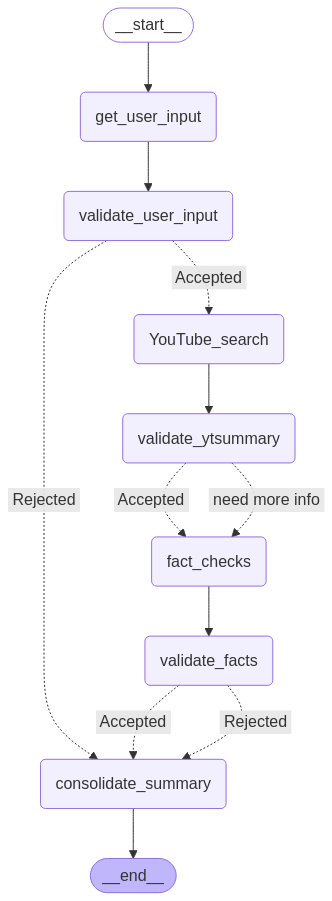

In [255]:
workflow = Graphbuilder.compile()
from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))

In [256]:
def get_user_input(state: State):
    print("b")
    return {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "Can we invest in  Crypto ?"
    }

In [257]:
workflow = Graphbuilder.compile()
state = get_user_input({})
final_State = workflow.invoke(state)
print("Final State: ", final_State)


b
b
Validating: 'Can we invest in  Crypto ?' against topic: 'Rich Dad Poor Dad'
Validation result: True | Raw response: 'true'
Accepted

=== Starting YouTube Search ===
YouTube Search... Rich Dad Poor Dad on  Robert Kiyosaki
✅ Valid search results found
✅ FAISS index created successfully
✅ YouTube summary generated successfully

=== Validating YouTube Summary for 'Can we invest in  Crypto ?' ===
Raw validation response: VALID
need more info
🔍 No specific search terms - using author/topic

=== Validating Factual Accuracy ===
Fact check validation result: True
Accepted
Final State:  {'topic': 'Rich Dad Poor Dad', 'author': 'Robert Kiyosaki', 'question': 'Can we invest in  Crypto ?', 'objective_check': True, 'youtube_summary': 'Investing in Crypto can be a risky but potentially rewarding endeavor. It is essential to have a solid understanding of the market and the technology behind cryptocurrencies before diving in. Remember, financial intelligence is key in any investment, including Cryp

In [258]:
from IPython.display import Markdown
Markdown(final_State ['generate_summary'])

As Robert Kiyosaki's analytical clone specializing in Rich Dad Poor Dad, my perspective is clear: when it comes to investing in Crypto, there are both opportunities and risks that must be carefully considered. 

In the world of cryptocurrencies, the potential for rewards is significant, but so is the risk. Just as in any investment, financial intelligence is key. It is crucial to educate yourself thoroughly on the market and the technology behind cryptocurrencies before diving in. Only by understanding the intricacies of this rapidly evolving market can you make informed decisions and potentially reap the rewards.

In his series of books, including the groundbreaking Rich Dad Poor Dad, Robert Kiyosaki emphasizes the importance of financial education and understanding the principles of investing. He encourages readers to think critically about money and wealth, and to take control of their financial futures. Applying these principles to the world of Crypto, it is essential to assess the risks and opportunities with a discerning eye.

While Crypto may offer the potential for significant returns, it also carries the risk of volatility and uncertainty. As Kiyosaki has pointed out, the key to success in any investment is to be prepared for both the ups and downs of the market. By staying informed and continuously educating yourself, you can position yourself to make sound investment decisions and potentially thrive in the face of economic uncertainty.

In conclusion, investing in Crypto can be a lucrative opportunity for those who approach it with caution and financial intelligence. By following the principles outlined in Rich Dad Poor Dad and other works by Robert Kiyosaki, you can navigate the risks and opportunities of the Crypto market with confidence. Remember, the key to success lies in education, analysis, and a willingness to take calculated risks.